In [ ]:
#import packages
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow_datasets as tfds
#from plot_keras_history import plot_history

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# check versions
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [ ]:
# check version
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
# download
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteMB4P7E/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteMB4P7E/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteMB4P7E/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#see text before encoded
datasettext, infotext = tfds.load('imdb_reviews/plain_text', with_info=True,
                          as_supervised=True)
train_datasettext, test_datasettext = datasettext['train'], datasettext['test']

texttr = tf.concat([x for x, y in train_datasettext], axis = 0)
text = tf.concat([x  for x, y in test_datasettext], axis = 0)

texttr.numpy()
text.numpy()

KeyboardInterrupt: ignored

In [ ]:
# see how encoder works
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [ ]:
sample_string = 'Hello Northwestern Data Science Students.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))


Encoded string is [4025, 222, 4277, 4413, 878, 1848, 2675, 2975, 2509, 6623, 8044, 7975]
The original string: "Hello Northwestern Data Science Students."


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
4277 ----> North
4413 ----> western 
878 ----> Da
1848 ----> ta 
2675 ----> Sci
2975 ----> ence 
2509 ----> Stu
6623 ----> dent
8044 ----> s
7975 ----> .


In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
4277 ----> North
4413 ----> western 
878 ----> Da
1848 ----> ta 
2675 ----> Sci
2975 ----> ence 
2509 ----> Stu
6623 ----> dent
8044 ----> s
7975 ----> .


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
# do padding
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

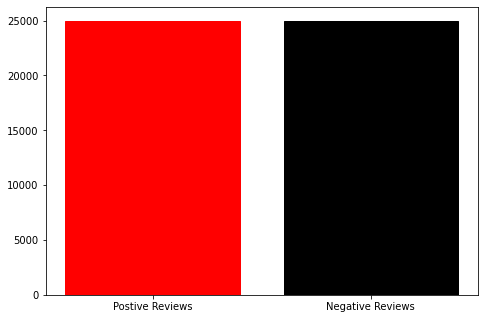

In [ ]:
#bar graphs
ytruetr = tf.concat([y for x, y in train_dataset], axis = 0)
ytrue = tf.concat([y  for x, y in test_dataset], axis = 0)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ytrue  = ytrue.numpy()
ytruetr = ytruetr.numpy()
negativesums = (ytruetr == 0).sum() + (ytrue == 0).sum()
positivesums = (ytruetr == 1).sum() + (ytrue == 1).sum()
bars = plt.bar(['Postive Reviews', 'Negative Reviews'], [positivesums, negativesums])
bars[0].set_color('r')
bars[1].set_color('black')

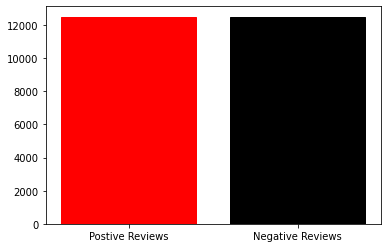

In [ ]:
negativesums = (ytruetr == 0).sum() 
positivesums = (ytruetr == 1).sum() 
bars = plt.bar(['Postive Reviews', 'Negative Reviews'], [positivesums, negativesums])
bars[0].set_color('r')
bars[1].set_color('black')

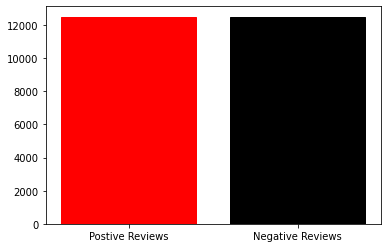

In [ ]:
negativesums = (ytrue == 0).sum() 
positivesums = (ytrue == 1).sum() 
bars = plt.bar(['Postive Reviews', 'Negative Reviews'], [positivesums, negativesums])
bars[0].set_color('r')
bars[1].set_color('black')

# MODEL 1

In [ ]:
# create simple RNN
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "BinaryClassificationModel.png", show_shapes=True)


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, model, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, model ,pad=False)
print(predictions)

In [ ]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text,model,pad=True)
print(predictions)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
# save train accuracy,loss to plot 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# shows plot
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# do metrics confusion matrix, f1 score, precision and recall do same for Model 2
from sklearn.metrics import confusion_matrix
predictions1 = model.predict(test_dataset)
classes = np.where(predictions1 >= 0.5, 1, 0)
ytrue = tf.concat([y for x, y in test_dataset], axis = 0)
print("test matrix")
print(confusion_matrix(ytrue,classes))

In [ ]:
truetrain1 = tf.concat([y for x, y in train_dataset], axis = 0)
predtrain1 = model.predict_classes(train_dataset)
print("test matrix")
print(confusion_matrix(truetrain1,predtrain1))

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("precision test score: ")
print(precision_score(ytrue,classes))
print(" ")
print("recall test score: ")
print(recall_score(ytrue,classes))


In [ ]:
from sklearn.metrics import f1_score
print("f1 test score")
print(f1_score(ytrue,classes))

# MODEL 2

In [ ]:
# create model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [ ]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
__________________________________________________

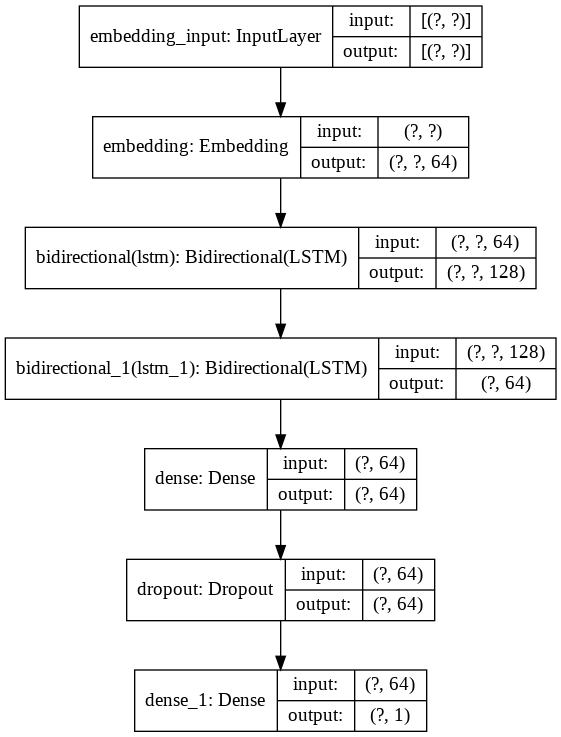

In [ ]:
keras.utils.plot_model(model2, "LSTMBinaryClassificationModel.png", show_shapes=True)


In [ ]:
history2 = model2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/5
391/391 [==============================] - 1437s 4s/step - loss: 0.6998 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 2/5
356/391 [==========================>...] - ETA: 2:08 - loss: 0.6931 - accuracy: 0.4975

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)
print('Test Accuracy: {}'.format(test_acc))
print('Test Loss: {}'.format(test_loss))

In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text,model, pad=False)
print(predictions) 

In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, model, pad=True)
print(predictions)

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

In [ ]:
plt.plot(range(1, len(acc) + 1), history2.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history2.history['val_accuracy'], label = 'Validation')
plt.ylim([0.5, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
plt.plot(range(1, len(loss) + 1), history2.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history2.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predtrain = model2.predict_classes(train_dataset)
print(confusion_matrix(truetrain1,predtrain))

In [ ]:
predictions2 = model2.predict(test_dataset)
classes2 = np.where(predictions2 >= 0.5, 1, 0)
print('test matrix')
print(confusion_matrix(ytrue, classes2))

In [ ]:
print("precision test score: ")
print(precision_score(ytrue, classes2))
print(" ")
print("recall test score: ")
print(recall_score(ytrue, classes2))

In [ ]:
print("f1 score")
print(f1_score(ytrue, classes2))